In [1]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'integrated_baseline'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs


In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/new_venv/lib/python3.13/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
# Paths and dataset config (integrated)
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_full_model_v1')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

gene_col = 'gene_symbols'
batch_col = 'sample'
label_col = 'cell_type'
layer_key = 'X'

RUN_TAG = 'full'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_full_model_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [4]:
# Create Geneformer instance and load model/vocab
batch_size = 4
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-20 23:47:59 | Using device cuda


INFO     | 2025-08-20 23:47:59 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


In [5]:
# Inspect dataset to determine columns and structure
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study', 'orig.ident']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

if 'gene_symbols' in ad.var.columns:
    gene_col = 'gene_symbols'
else:
    gene_col = None
print('gene_col ->', gene_col if gene_col else 'var.index')

print('n unique labels:', ad.obs[label_col].nunique() if label_col in ad.obs else 'NA')
print('label example counts:\n', ad.obs[label_col].astype(str).value_counts().head(20) if label_col in ad.obs else 'NA')


adata shape: (138727, 33541)
obs columns: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident']
var columns: []
label_col -> annotation
batch_col -> orig.ident
gene_col -> var.index
n unique labels: 16
label example counts:
 annotation
Epithelial           52081
Unknown              35593
Myeloid              11400
Fibroblast           11155
Malignant             6848
Lymphiod              6591
T_cell                5325
Normal epithelium     4603
Macrophage            1855
B_cell                1106
Endothelial           1049
Pericyte               760
Mast                   227
Dendritic              112
Lymphovascular          16
Plasma                   6
Name: count, dtype: int64


In [6]:
# Load and preprocess data to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(in_dataset_path))

inp.preprocess_data(
    gene_col=gene_col if gene_col else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_path = preprocessed_path / f'{dataset_name}_model_v1_full.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-20 23:52:18 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/integrated_with_quiescence.h5ad
WARNING  | 2025-08-20 23:55:42 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-20 23:56:03 | Matched 68.68% genes (19794/28819) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_full_model_v1/integrated_with_quiescence_model_v1_full.h5ad exists: False


In [7]:
# Verify/update columns post-preprocess
import scanpy as sc
pfile = str(preprocessed_path / f'{dataset_name}.h5ad')

ad_tmp = sc.read(pfile)
if 'cell_type' not in ad_tmp.obs.columns and label_col in ad_tmp.obs.columns:
    ad_tmp.obs['cell_type'] = ad_tmp.obs[label_col].astype(str).values
    print("Added 'cell_type' column from:", label_col)
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values

ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


... storing 'cell_type' as categorical


Added 'cell_type' column from: annotation
Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_full_model_v1/integrated_with_quiescence.h5ad


In [10]:
# Tokenize to HF Dataset on disk and persist

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col=label_col
)

# TRUNCATION - Applied immediately after tokenization
print("=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===")

# Truncate sequences to 2048 tokens to fit model limits
def truncate_sequences(example):
    # Force all sequences to be exactly 2048 tokens
    if len(example["input_ids"]) > 2048:
        example["input_ids"] = example["input_ids"][:2048]
    elif len(example["input_ids"]) < 2048:
        # Pad with zeros to reach 2048
        example["input_ids"] = example["input_ids"] + [0] * (2048 - len(example["input_ids"]))
    
    example["length"] = 2048  # Always 2048
    return example

print(f"Original dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length before truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    if 'length' in geneform.tokenized_dataset[0]:
        print(f"Sample length field before truncation: {geneform.tokenized_dataset[0]['length']}")

# Apply truncation
print("Applying truncation...")
geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)

if len(geneform.tokenized_dataset) > 0:
    print(f"Sample input_ids length after truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
    print(f"Sample length field after truncation: {geneform.tokenized_dataset[0]['length']}")

# Verify all sequences are within limit
max_length = max([len(example['input_ids']) for example in geneform.tokenized_dataset])
print(f"Maximum sequence length after truncation: {max_length}")
if max_length > 2048:
    print("⚠️ WARNING: Some sequences are still longer than 2048!")
else:
    print("✅ All sequences are ≤ 2048 tokens")

# Avoid deletion issues by using timestamped directory
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dataset_dir = preprocessed_path / f'{dataset_name}_full_model_v1_{timestamp}.dataset'
print(f'Using timestamped dataset directory: {dataset_dir}')

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Successfully saved truncated tokenized dataset to disk.')
except Exception as e:
    print('Error saving to disk:', e)
    # Fallback: try saving with different name
    dataset_dir_fallback = preprocessed_path / f'{dataset_name}_truncated_fallback.dataset'
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir_fallback))
    print(f'Saved truncated dataset to fallback location: {dataset_dir_fallback}')
    dataset_dir = dataset_dir_fallback

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name,
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': label_col,
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_full_model_v1_{timestamp}.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'{dataset_name}.dataset')
print('Archived tokenized dataset to:', archive_path)

WARNING  | 2025-08-21 00:26:14 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_full_model_v1/integrated_with_quiescence.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_full_model_v1/integrated_with_quiescence.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 138727
Sample input_ids length: 2495
=== APPLYING TRUNCATION TO TOKENIZED SEQUENCES ===
Original dataset size: 138727
Sample input_ids length before truncation: 2497
Sample length field before truncation: 2497
Applying truncation...
Sample input_ids length after truncation: 2048
Sample length field after truncation: 2048
Maximum sequence length after truncation: 2048
✅ All sequences are ≤ 2048 tokens
Using timestamped dataset directory: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/integrated_with_quiescence_full_model_v1/integrated_with_quiescence_full_model_v1_20250821_00384

In [11]:
# dataset_dir = preprocessed_path / f'{dataset_name}_model_v1_full.dataset'

# if dataset_dir.exists():
#     geneform.load_tokenized_dataset(str(dataset_dir))
#     print('Loaded existing tokenized dataset.')
# else:
#     geneform.tokenize_data(
#         adata_path=str(h5_path),
#         dataset_path=str(preprocessed_path),
#         cell_type_col=label_col
#     )
#     print('Tokenized and loaded dataset.')

In [12]:
# Load back, extract embeddings, and quick eval

geneform.load_tokenized_dataset(str(dataset_dir))

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key=label_col,
    batch_key=batch_col
)

eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))

eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')


Geneformer (extracting embeddings):   0%|          | 0/34682 [00:00<?, ?it/s]

Geneformer (extracting embeddings): 100%|██████████| 34682/34682 [36:05<00:00, 16.01it/s]
DEBUG    | 2025-08-21 01:20:38 | Extracting output from 500 cells
WARNING  | 2025-08-21 01:20:50 | adata_ has 138727 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-21 01:20:51 | Computing metrics for annotation
DEBUG    | 2025-08-21 01:20:56 | NMI_cluster/label: 0.0717
ARI_cluster/label: 0.0191
ASW_label: 0.2565
graph_conn: 0.4344
ASW_batch: 0.4573
ASW_label/batch: 0.6797
PCR_batch: 0.0360
avg_bio: 0.1157
DEBUG    | 2025-08-21 01:20:56 | NMI_cluster/label for annotation: 0.07165943801327211
DEBUG    | 2025-08-21 01:20:56 | ARI_cluster/label for annotation: 0.01911559366867003
DEBUG    | 2025-08-21 01:20:56 | ASW_label for annotation: 0.25646618008613586
DEBUG    | 2025-08-21 01:20:56 | graph_conn for annotation: 0.4343857103437912
DEBUG    | 2025-08-21 01:20:56 | ASW_batch for annotation: 0.4573131799697876
DEBUG    | 2025-08-21 01:20:56 | ASW_label/batch for annotation: 0.67971742153167

,metric,label,value
0,NMI_cluster/label,annotation,0.071659
1,ARI_cluster/label,annotation,0.019116
2,ASW_label,annotation,0.256466
3,graph_conn,annotation,0.434386
4,ASW_batch,annotation,0.457313
5,ASW_label/batch,annotation,0.679717
6,PCR_batch,annotation,0.036003
7,avg_bio,annotation,0.115747


In [13]:
# Ensemble evaluation and saving
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col=label_col,
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V1-10M',
    'dataset_name': dataset_name,
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_integrated_results_model_v1_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_integrated_metrics_model_v1_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-21 01:21:12 | Initialized GeneformerEnsembleMetrics with 138727 cells and 16 classes
INFO     | 2025-08-21 01:21:12 | Classes: ['B_cell', 'Dendritic', 'Endothelial', 'Epithelial', 'Fibroblast', 'Lymphiod', 'Lymphovascular', 'Macrophage', 'Malignant', 'Mast', 'Myeloid', 'Normal epithelium', 'Pericyte', 'Plasma', 'T_cell', 'Unknown']
INFO     | 2025-08-21 01:21:12 | Embedding shape: (138727, 256)
INFO     | 2025-08-21 01:21:12 | Input rankings length: 138727
INFO     | 2025-08-21 01:21:12 | Output rankings length: 138727
INFO     | 2025-08-21 01:21:13 | Evaluated embedding_only (α=0.0): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=0.0: F1=0.025, AUC=0.640, Acc=0.025


INFO     | 2025-08-21 01:21:14 | Evaluated embedding_only (α=0.1): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=0.1: F1=0.025, AUC=0.640, Acc=0.025


INFO     | 2025-08-21 01:21:15 | Evaluated embedding_only (α=0.3): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=0.3: F1=0.025, AUC=0.640, Acc=0.025


INFO     | 2025-08-21 01:21:15 | Evaluated embedding_only (α=0.5): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=0.5: F1=0.025, AUC=0.640, Acc=0.025


INFO     | 2025-08-21 01:21:16 | Evaluated embedding_only (α=0.7): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=0.7: F1=0.025, AUC=0.640, Acc=0.025


INFO     | 2025-08-21 01:21:17 | Evaluated embedding_only (α=0.9): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=0.9: F1=0.025, AUC=0.640, Acc=0.025


INFO     | 2025-08-21 01:21:18 | Evaluated embedding_only (α=1.0): Accuracy=0.025, F1=0.025, AUC-ROC=0.640


alpha=1.0: F1=0.025, AUC=0.640, Acc=0.025
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_results_model_v1_full.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_metrics_model_v1_full.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_confusion_matrix_model_v1_full.png


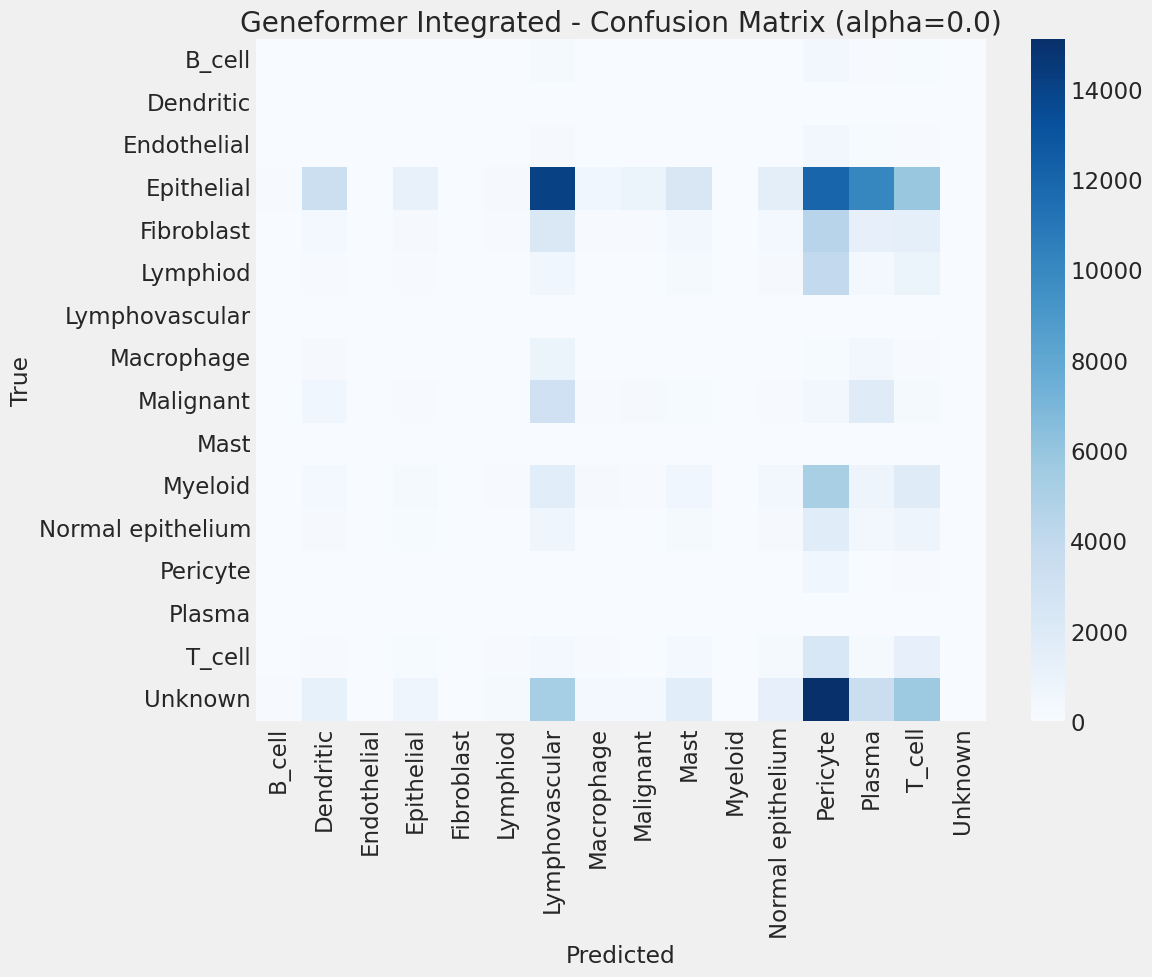

In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=em.class_names,
            yticklabels=em.class_names, ax=ax)
ax.set_title(f'Geneformer Integrated - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_integrated_confusion_matrix_model_v1_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_umap_coords_model_v1_full.csv


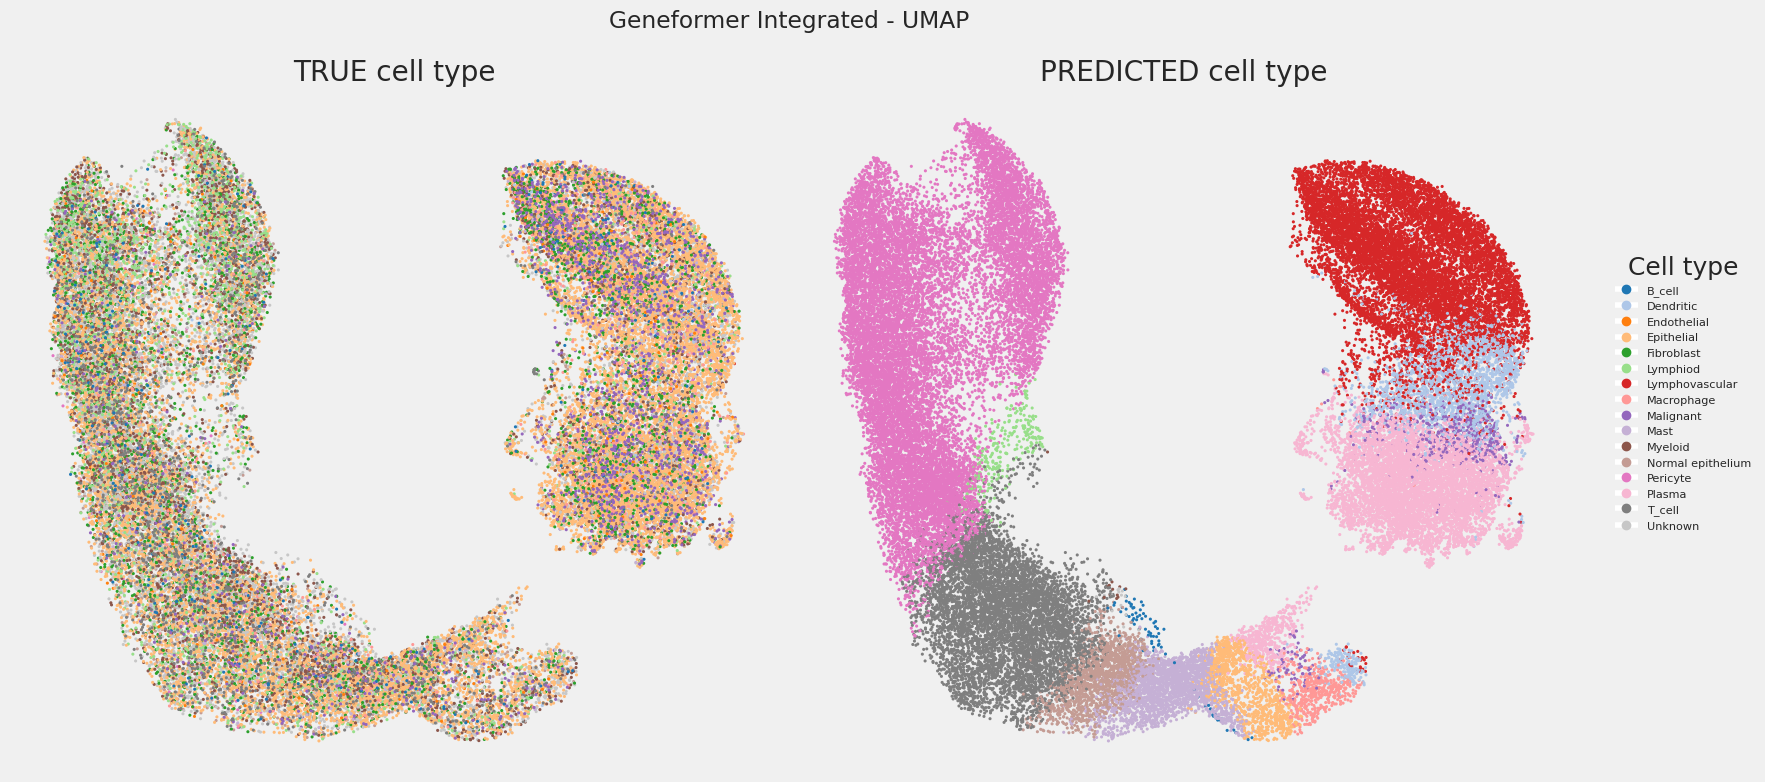

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/integrated_baseline/model_outputs/geneformer_integrated_umap_true_pred_with_legend_model_v1_full.png


In [15]:
# UMAP of true vs predicted labels with side legend
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
class_names = list(em.class_names)
preds_arr = np.asarray(preds)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_names_arr = np.array(class_names, dtype=object)
true_names = class_names_arr[labels_encoded]
pred_names = class_names_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

unique_levels = list(class_names)
if len(unique_levels) <= 20:
    pal_colors = sns.color_palette('tab20', n_colors=len(unique_levels))
else:
    pal_colors = sns.color_palette('hls', n_colors=len(unique_levels))
palette = dict(zip(unique_levels, pal_colors))

coords_path = MODEL_OUT / f'geneformer_integrated_umap_coords_model_v1_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE cell type'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED cell type'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in unique_levels
]
fig.legend(handles=handles, labels=unique_levels, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='xx-small', title='Cell type')
fig.suptitle(f'Geneformer Integrated - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_integrated_umap_true_pred_with_legend_model_v1_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)


In [17]:
# Performance metrics summary
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
)

# results_path = MODEL_OUT / f'geneformer_integrated_results_full_{RUN_TAG}.pt'
results_path = MODEL_OUT / f'geneformer_integrated_results_model_v1_{RUN_TAG}.pt'

res = None
try:
    from torch.serialization import safe_globals, add_safe_globals
    try:
        with safe_globals([np.core.multiarray._reconstruct]):
            res = torch.load(results_path, map_location='cpu')
        print('Loaded results with safe_globals allowlist')
    except Exception:
        add_safe_globals([np.core.multiarray._reconstruct])
        res = torch.load(results_path, map_location='cpu')
        print('Loaded results after add_safe_globals')
except Exception:
    pass
if res is None:
    res = torch.load(results_path, map_location='cpu', weights_only=False)
    print('Loaded results with weights_only=False')

model_name = res.get('model_name', 'UnknownModel')
dataset = res.get('dataset_name', 'UnknownDataset')
best_alpha = res.get('best_alpha', None)
class_names = list(res.get('class_names', []))

labels_t = res['labels']
preds_t = res['preds']
labels_np = labels_t.cpu().numpy() if hasattr(labels_t, 'cpu') else np.array(labels_t)
preds_np = preds_t.cpu().numpy() if hasattr(preds_t, 'cpu') else np.array(preds_t)

print(f'Model: {model_name}')
print(f'Dataset: {dataset}')
if best_alpha is not None:
    print(f'Best alpha (ensemble): {best_alpha}')

metrics = res.get('evaluation_metrics', None)
if metrics is not None:
    print('\nSaved evaluation metrics:')
    for k in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'avg_precision']:
        if k in metrics:
            print(f'  {k}: {metrics[k]:.4f}')
else:
    acc = accuracy_score(labels_np, preds_np)
    prec, rec, f1, _ = precision_recall_fscore_support(labels_np, preds_np, average='macro', zero_division=0)
    print('\nComputed metrics (macro):')
    print(f'  accuracy: {acc:.4f}')
    print(f'  precision: {prec:.4f}')
    print(f'  recall: {rec:.4f}')
    print(f'  f1_score: {f1:.4f}')

if class_names and len(class_names) > int(labels_np.max()):
    target_names = class_names
else:
    n_classes = int(max(labels_np.max(), preds_np.max())) + 1
    target_names = [f'Class_{i}' for i in range(n_classes)]

print('\nClassification report:')
print(classification_report(labels_np, preds_np, target_names=target_names, digits=4))


Loaded results with weights_only=False
Model: Geneformer-V1-10M
Dataset: integrated_with_quiescence
Best alpha (ensemble): 0.0

Saved evaluation metrics:
  accuracy: 0.0254
  precision: 0.3235
  recall: 0.0254
  f1_score: 0.0251
  auc_roc: 0.6404
  avg_precision: 0.0764

Classification report:
                   precision    recall  f1-score   support

           B_cell     0.0176    0.0036    0.0060      1106
        Dendritic     0.0026    0.1518    0.0052       112
      Endothelial     0.0000    0.0000    0.0000      1049
       Epithelial     0.3915    0.0221    0.0419     52081
       Fibroblast     0.0000    0.0000    0.0000     11155
         Lymphiod     0.0549    0.0068    0.0121      6591
   Lymphovascular     0.0004    0.7500    0.0008        16
       Macrophage     0.0129    0.0108    0.0118      1855
        Malignant     0.1154    0.0307    0.0485      6848
             Mast     0.0032    0.0881    0.0062       227
          Myeloid     0.2647    0.0008    0.0016     11